In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as lin
from cs771 import plotData as pd, utils, genSyntheticData as gsd
import random

In [3]:
def getGramMatrix( X, Y, kernel, p = 1, c = 0, g = 1.0 ):
    # Check if these are 1D datasets
    if len( X.shape ) == 1:
        X = X[:, np.newaxis]
    if len( Y.shape ) == 1:
        Y = Y[:, np.newaxis]
    if kernel == "linear":
        return np.matmul( X, Y.T )
    elif kernel == "poly":
        return np.power( np.matmul( X, Y.T ) + c, p )
    elif kernel == "rbf":
        return np.exp( - g * utils.getAllPairsDistances( X, Y ) )

# Perform the k-means++ initialization in RKHS in dual form
def doKMPPInit( G, k ):
    n = X.shape[0]
    idx = np.zeros( (k,), dtype = int )
    # Find out the squared Hilbertian (essentially Euclidean) norms of the data points in RKHS
    norms = np.diag( G )
    # Calculate pairwise squared Hilbertian distances in RKHS
    D = - 2 * G + norms + norms[:, np.newaxis]
    # Choose a random data point and make it a centroid
    idx[0] = random.randint( 0, n-1 )
    for t in range( 1, k ):
        # For all data points, find the squared Hilbertian distance to the closest centroid
        dist = np.min( D[:, idx[0:t]], axis = 1 )
        # Choose the next centroid to be one that is likely to be far from all currently chosen centroids
        probs = dist/np.sum(dist)
        # Numerical issues in Python may cause ||x-x||_2 to be not exactly zero
        probs[probs < 1e-10] = 0
        idx[t] = np.random.choice( np.arange( n ), p = probs )
    init = np.zeros( (k, n) )
    init[ np.arange(k), idx ] = 1
    # The following normalization is vacuous since
    # every cluster has just one point at the moment
    init / np.sum( init, axis = 1 )[:,np.newaxis]
    return init, idx

# We know that there are equal number of points per cluster
# as well as how these points are stacked - use this privileged
# info to sample a point from each cluster
# k-means++ should also be able to give such an initialization if 
# the clusters are indeed well-separated, but after several trials
def doCheatInit( G, k ):
    n = G.shape[0]
    nPerClass = n//k
    idx = np.arange( k )*nPerClass + random.randint( 0, nPerClass - 1 )
    init = np.zeros( (k, n) )
    init[ np.arange(k), idx ] = 1
    init / np.sum( init, axis = 1 )[:,np.newaxis]
    return init, idx

# For every point, return which is the closest centroid in terms of Hilbertian distance
def getClosestCentroid( G, alphaVals ):
    k = alphaVals.shape[0]
    n = G.shape[0]
    # Find squared Hilbertian norms of the current centroids
    centroidNorms = np.zeros( (k,) )
    for i in range( k ):
        alphaThisCluster = alphaVals[i,:]
        centroidNorms[i] = alphaThisCluster.dot( G.dot( alphaThisCluster ) )
    # Find the Hilbertian distance of each point from each centroid
    # The first term in the following expression np.diag( G ) is not
    # actually required since it does not affect the argmin at all
    D = np.zeros( (k, n) )
    D = D + np.diag( G ) - 2 * np.matmul( alphaVals, G ) + centroidNorms[:, np.newaxis]
    return np.argmin( D, axis = 0 )

# Update every centroid to the mean of all data points assigned to that cluster
def updateCentroids( G, z, k, prevAlphaVals ):
    alphaVals = np.zeros( (k, G.shape[0]) )
    for i in range( k ):
        if z[z == i].size > 0:
            alphaVals[i, z == i] = 1
            # Normalize the alpha vector
            alphaVals[i,:] = alphaVals[i,:]/np.sum( alphaVals[i,:] )
        # If some cluster is empty, return the old value of its centroid
        else:
            print( "Warning: empty cluster detected" )
            alphaVals[i,:] = prevAlphaVals[i,:]
    if lin.norm( alphaVals - prevAlphaVals, "fro" ) < 1e-15:
        converged = True
        print( "Converged within ", end = '')
    else:
        converged = False
    return (alphaVals, converged)

# Execute the Llyod's algorithm in RKHS
def dokmeans( G, k, init, niter ):
    alphaVals = init
    # Perform alternating minimization for niter steps
    for t in range( niter ):
        z = getClosestCentroid( G, alphaVals )
        alphaVals, conv = updateCentroids( G, z, k, alphaVals )
        if conv:
            print( t, "iterations" )
            return (alphaVals, z)
    return (alphaVals, z)

d = 2
n = 100

X1 = gsd.genSphericalData( d, n, [0, 0], 10 )
X2 = gsd.genSphericalData( d, n, [0, 0], 2)
X = np.vstack( (X1, X2) )

Converged within 1 iterations


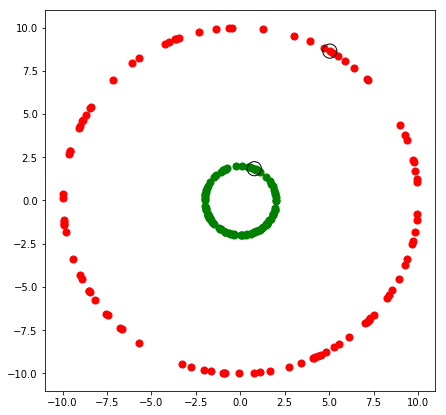

In [4]:
k = 2

G = getGramMatrix( X, X, "rbf", p = 2, c = 1, g = 1.0 )

# init, idx = doKMPPInit( G, k )
# Cheating a bit to reduce the number of trials required
# to get good initialization :)
init, idx = doCheatInit( G, k )
(alphaVals, z) = dokmeans( G, k, init, 100 )

fig = pd.getFigure( 7, 7 )
pd.plot2D( X[z == 0], fig, size = 50, color = 'r', marker = 'o' )
pd.plot2D( X[z == 1], fig, size = 50, color = 'g', marker = 'o' )
# Highlight the points used to initialize kernel k-means
pd.plot2D( X[idx,:] , fig, size = 200, color = 'k', marker = 'o', empty = True )

In [5]:
d = 2
n = 100

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,-2] )

tmp1 = gsd.genMoonData( d, n, mu1, 1 )
tmp2 = gsd.genMoonData( d, n, mu2, 5, flipped = True )
tmp3 = gsd.genMoonData( d, n, mu3, 10 )
X = np.vstack( (tmp1, tmp2, tmp3) )

Converged within 10 iterations


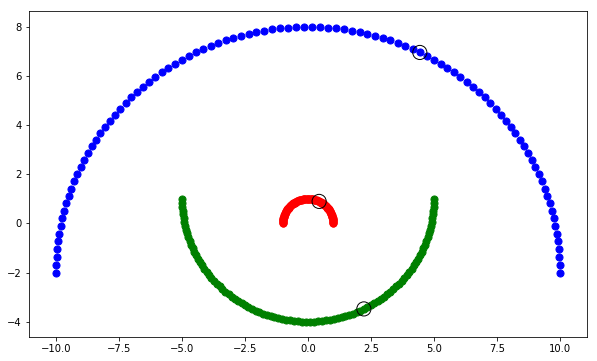

In [11]:
k = 3

G = getGramMatrix( X, X, "rbf", p = 2, c = 1, g = 0.1 )

# init, idx = doKMPPInit( G, k )
# Cheating a bit to reduce the number of trials required
# to get good initialization :)
init, idx = doCheatInit( G, k )
(alphaVals, z) = dokmeans( G, k, init, 100 )

fig = pd.getFigure( 10, 6 )
pd.plot2D( X[z == 0], fig, size = 50, color = 'r', marker = 'o' )
pd.plot2D( X[z == 1], fig, size = 50, color = 'g', marker = 'o' )
pd.plot2D( X[z == 2], fig, size = 50, color = 'b', marker = 'o' )
# Highlight the points used to initialize kernel k-means
pd.plot2D( X[idx,:] , fig, size = 200, color = 'k', marker = 'o', empty = True )